In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install kmodes

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, kmeans_plusplus
from kmodes.kprototypes import KPrototypes
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
data_dir = "/content/drive/MyDrive/Upgrad_Lectures/Clustering/Clustering Data.xlsx"

In [6]:
df = pd.read_excel(data_dir)
## df = pd.read_excel('Clustering Data.xlsx') ## If reading data from local

In [7]:
df

,Gender,Age,Height,Weight,family_history,SMOKE
0,Female,21.000000,1.620000,64.000000,yes,no
1,Female,21.000000,1.520000,56.000000,yes,yes
2,Male,23.000000,1.800000,77.000000,yes,no
3,Male,27.000000,1.800000,87.000000,no,no
4,Male,22.000000,1.780000,89.800000,no,no
...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,no
2107,Female,21.982942,1.748584,133.742943,yes,no
2108,Female,22.524036,1.752206,133.689352,yes,no
2109,Female,24.361936,1.739450,133.346641,yes,no


In [8]:
df['Gender'] = np.where(df['Gender']=='Female',1,0)
df['family_history'] = np.where(df['family_history']=='yes',1,0)
df['SMOKE'] = np.where(df['SMOKE']=='yes',1,0)

In [9]:
# Extracting feature columns
X_continuous = df[['Age', 'Height', 'Weight']]
X_categorical = df[['Gender','family_history','SMOKE']]

In [10]:
# Scaling continuous data
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X_continuous)

In [11]:
# Combine scaled continuous and categorical data
X_combined = np.hstack((X_continuous_scaled, X_categorical))

In [12]:
X_combined

array([[-0.52212439, -0.87558934, -0.86255819,  1.        ,  1.        ,
         0.        ],
       [-0.52212439, -1.94759928, -1.16807699,  1.        ,  1.        ,
         1.        ],
       [-0.20688898,  1.05402854, -0.36609013,  0.        ,  1.        ,
         0.        ],
       ...,
       [-0.28190933,  0.54167211,  1.79886776,  1.        ,  1.        ,
         0.        ],
       [ 0.00777624,  0.40492652,  1.78577968,  1.        ,  1.        ,
         0.        ],
       [-0.10211908,  0.39834438,  1.7905916 ,  1.        ,  1.        ,
         0.        ]])

### KMeans

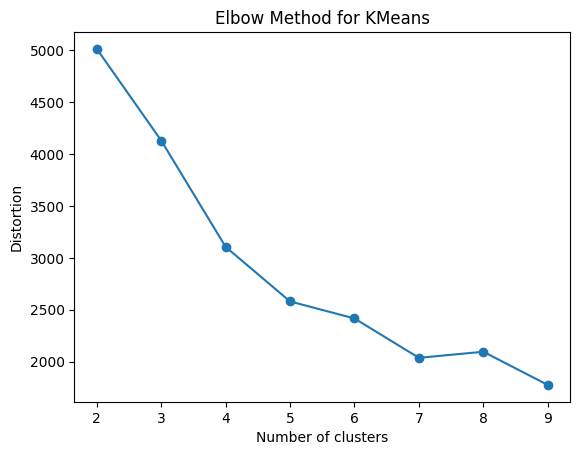

In [13]:
distortions = []
krange = range(2,10)
for k in krange:
    kmeansModel = KMeans(n_clusters=k, random_state=42).fit(X_combined)
    distortions.append(kmeansModel.inertia_)
plt.plot(krange, distortions, marker='o')
plt.title(f'Elbow Method for KMeans')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [14]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_continuous_scaled)
df['KMeans_Cluster'] = kmeans_labels

### K Prototype

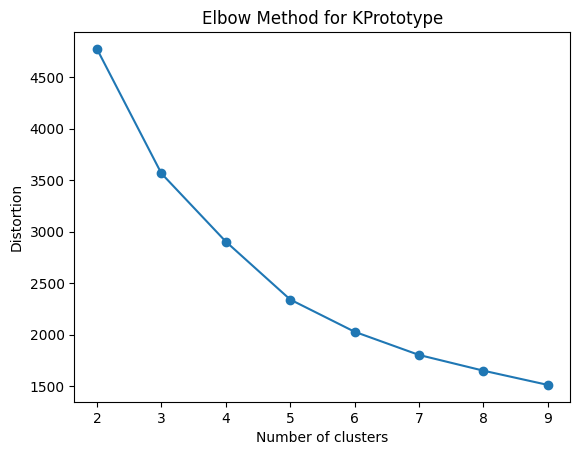

In [15]:
distortions = []
krange = range(2,10)
for k in krange:
    kprotoModel = KPrototypes(n_clusters=k, random_state=42).fit(X_combined,categorical = [3,4,5])
    distortions.append(kprotoModel.cost_)
plt.plot(krange, distortions, marker='o')
plt.title(f'Elbow Method for KPrototype')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [16]:
kprotoModel = KPrototypes(n_clusters=5, random_state=42)
kproto_labels = kprotoModel.fit_predict(X_combined, categorical=[3,4,5])
df['KPrototype_Cluster'] = kproto_labels

### Hierarchical

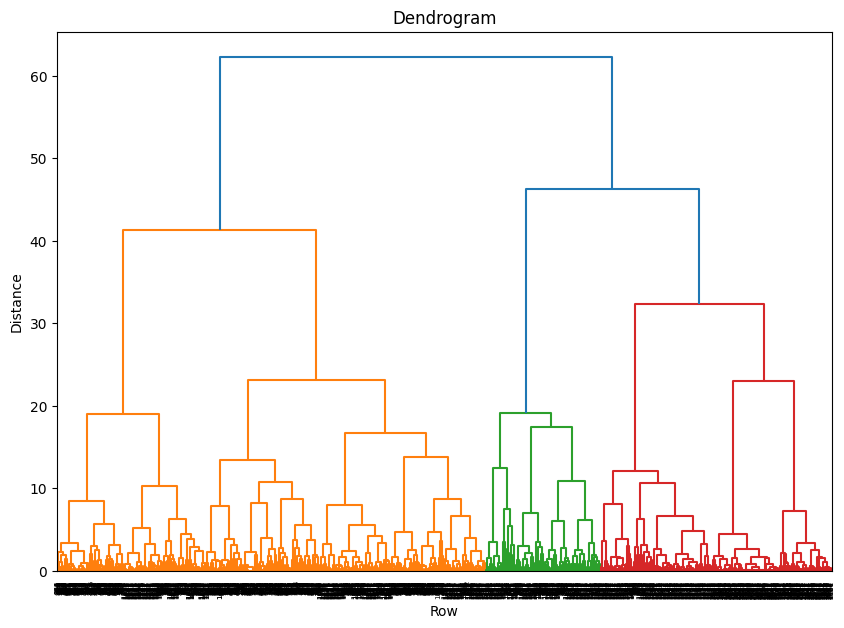

In [17]:
# Generate the linkage matrix
Z = linkage(X_combined, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Row')
plt.ylabel('Distance')
plt.show()

In [18]:
# Perform agglomerative clustering
agg_clustering = AgglomerativeClustering(n_clusters=4)
agglo_labels = agg_clustering.fit_predict(X_combined)
df['Agglo_Cluster'] = agglo_labels

### DBSCAN

In [19]:
dbscan = DBSCAN(eps=1.5, min_samples=4)
dbscan_labels = dbscan.fit_predict(X_combined)
df['DBSCAN_Cluster'] = dbscan_labels

### Performance Comparison

In [20]:

def clustering_performance(X, labels, method):
    if len(set(labels)) > 1:
        score = silhouette_score(X, labels)
        print(f'Silhouette Score for {method}: {score:.2f}')
    else:
        print(f'{method} resulted in a single cluster.')

clustering_performance(X_combined, kmeans_labels, 'K-Means')
clustering_performance(X_combined, kproto_labels, 'K-Prototype')
clustering_performance(X_combined, dbscan_labels, 'DBSCAN')
clustering_performance(X_combined, agglo_labels, 'Agglo_Cluster')

Silhouette Score for K-Means: 0.29
Silhouette Score for K-Prototype: 0.30
Silhouette Score for DBSCAN: 0.49
Silhouette Score for Agglo_Cluster: 0.26


#### Cluster Profiling

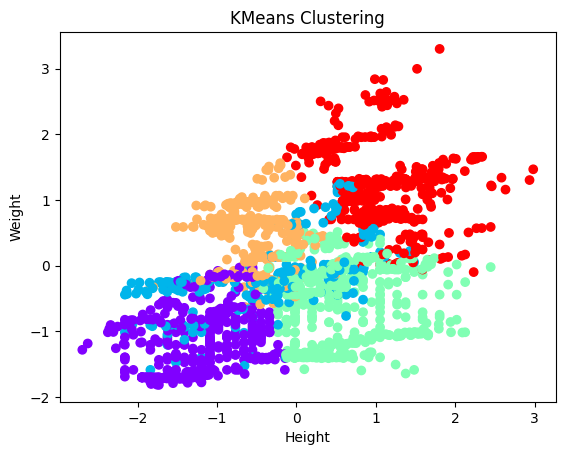

In [21]:
# Plot the clusters
plt.scatter(X_combined[:, 1], X_combined[:, 2], c=kmeans_labels, cmap='rainbow')
plt.title('KMeans Clustering')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

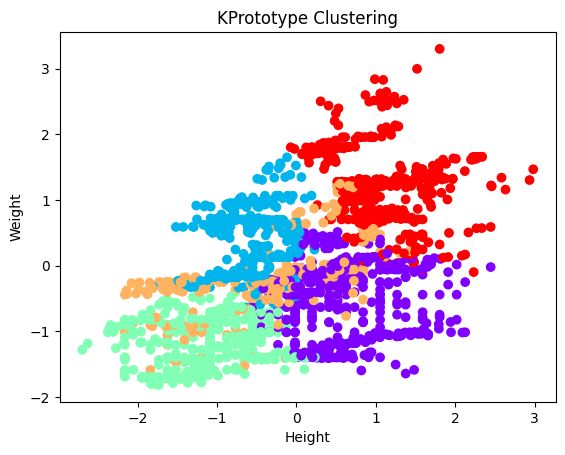

In [22]:
# Plot the clusters
plt.scatter(X_combined[:, 1], X_combined[:, 2], c=kproto_labels, cmap='rainbow')
plt.title('KPrototype Clustering')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

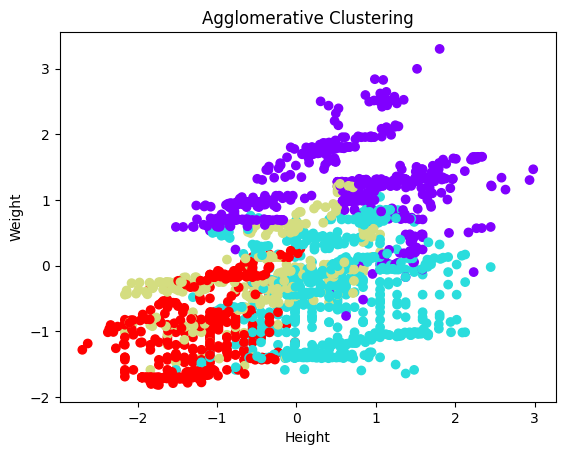

In [23]:
# Plot the clusters
plt.scatter(X_combined[:, 1], X_combined[:, 2], c=agglo_labels, cmap='rainbow')
plt.title('Agglomerative Clustering')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

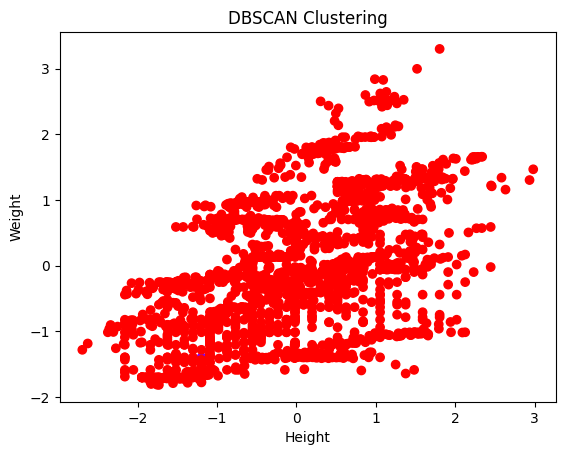

In [24]:
# Plot the clusters
plt.scatter(X_combined[:, 1], X_combined[:, 2], c=dbscan_labels, cmap='rainbow')
plt.title('DBSCAN Clustering')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

<Axes: xlabel='KMeans_Cluster', ylabel='Height'>

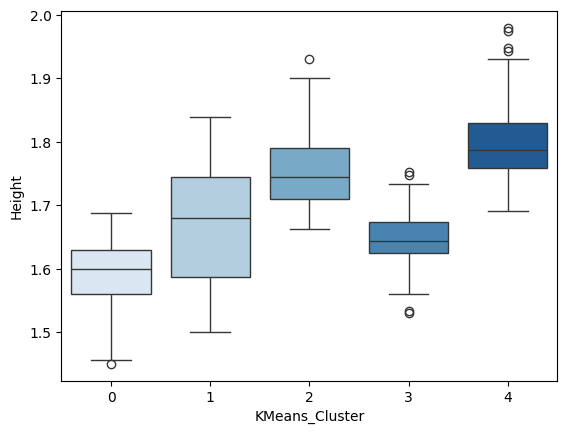

In [25]:
sns.boxplot(x = df['KMeans_Cluster'], y = df['Height'],palette = 'Blues')

<Axes: xlabel='KMeans_Cluster', ylabel='Weight'>

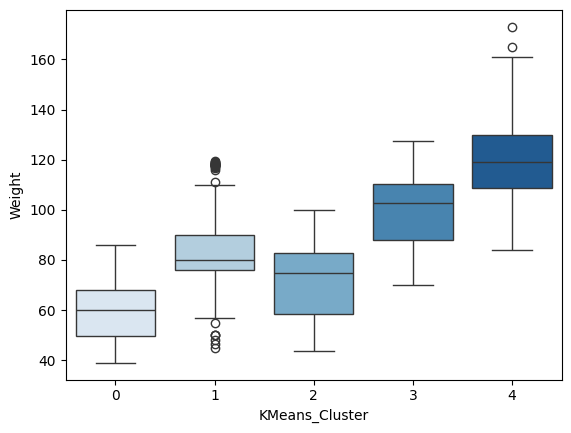

In [26]:
sns.boxplot(x = df['KMeans_Cluster'], y = df['Weight'],palette = 'Blues')

<Axes: xlabel='KMeans_Cluster', ylabel='Age'>

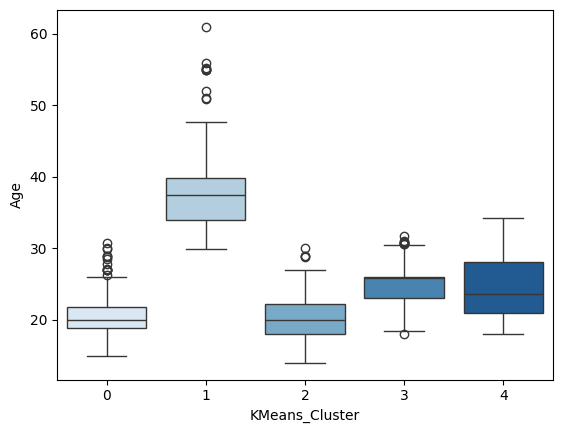

In [27]:
sns.boxplot(x = df['KMeans_Cluster'], y = df['Age'],palette = 'Blues')